<a href="https://colab.research.google.com/github/K-Saritha/DAS/blob/main/Fraud_detection_mlproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV  # Change to RandomizedSearchCV
from scipy.stats import randint


In [ ]:
desired_sample_size_per_class=5000
df=pd.read_csv('/content/PS_20174392719_1491204439457_log.csv')

# Define the number of samples per class
sample_size_per_class = min(df['isFraud'].value_counts().min(), desired_sample_size_per_class)

# Sample data for each class
df_reduced = df.groupby('isFraud', group_keys=False).apply(
    lambda x: x.sample(n=sample_size_per_class, random_state=42)
).reset_index(drop=True)


# Separate features and target
X = df_reduced.drop(columns=['isFraud'])
y = df_reduced['isFraud']

    # One-hot encoding
X = pd.get_dummies(X)

    # Print dataset info
print(f"Total samples: {len(df_reduced)}")
print(f"Fraud distribution:\n{y.value_counts(normalize=True)}")


<ipython-input-14-86fd8c529f27>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reduced = df.groupby('isFraud', group_keys=False).apply(


Total samples: 6854
Fraud distribution:
isFraud
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [ ]:
# Advanced Preprocessing
def preprocess_features(X_train, X_test):
    # Imputation
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    return X_train_scaled, X_test_scaled

# Apply preprocessing
X_train_processed, X_test_processed = preprocess_features(X_train, X_test)


In [ ]:
def tune_hyperparameters(X_train, y_train):
    # Subset data for tuning to save time
    X_subset, _, y_subset, _ = train_test_split(
        X_train, y_train, train_size=0.5, random_state=42
    )
    print(f"Using subset of data for tuning - Shape: {X_subset.shape}")

    # Random Forest parameter grid
    param_grid_rf = {
        'n_estimators': [100],
        'max_depth': [10],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    }

    # XGBoost parameter grid
    param_grid_xgb = {
        'n_estimators': [100],
        'max_depth': [6],
        'learning_rate': [0.1],
        'subsample': [0.8]
    }

    # Random Forest tuning
    rf_grid = RandomizedSearchCV(
        RandomForestClassifier(class_weight='balanced', random_state=42),
        param_grid_rf,
        n_iter=5,
        cv=3,
        scoring='f1',
        random_state=42
    )

    # XGBoost tuning
    xgb_grid = RandomizedSearchCV(
        XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='hist'
        ),
        param_grid_xgb,
        n_iter=3,
        cv=3,
        scoring='f1',
        random_state=42
    )

    # Logistic Regression (no tuning)
    lr_model = LogisticRegression(class_weight='balanced', random_state=42)

    print("Fitting Random Forest...")
    rf_grid.fit(X_subset, y_subset)
    rf_best = rf_grid.best_estimator_
    print("RF Best Params:", rf_grid.best_params_)

    print("Fitting XGBoost...")
    xgb_grid.fit(X_subset, y_subset)
    xgb_best = xgb_grid.best_estimator_
    print("XGB Best Params:", xgb_grid.best_params_)

    print("Fitting Logistic Regression...")
    lr_model.fit(X_train, y_train)

    return rf_best, xgb_best, lr_model

rf_best, xgb_best, lr_model = tune_hyperparameters(X_train_processed, y_train)

Using subset of data for tuning - Shape: (2398, 13665)
Fitting Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RF Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
Fitting XGBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:20:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:20:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:21:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:21:14] WARNING: /workspace/src/learner.cc:740: 
Param

XGB Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
Fitting Logistic Regression...


Visualizing feature importance for XGBoost...


<ipython-input-24-e18b3d9c351e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_10_features, palette='viridis')


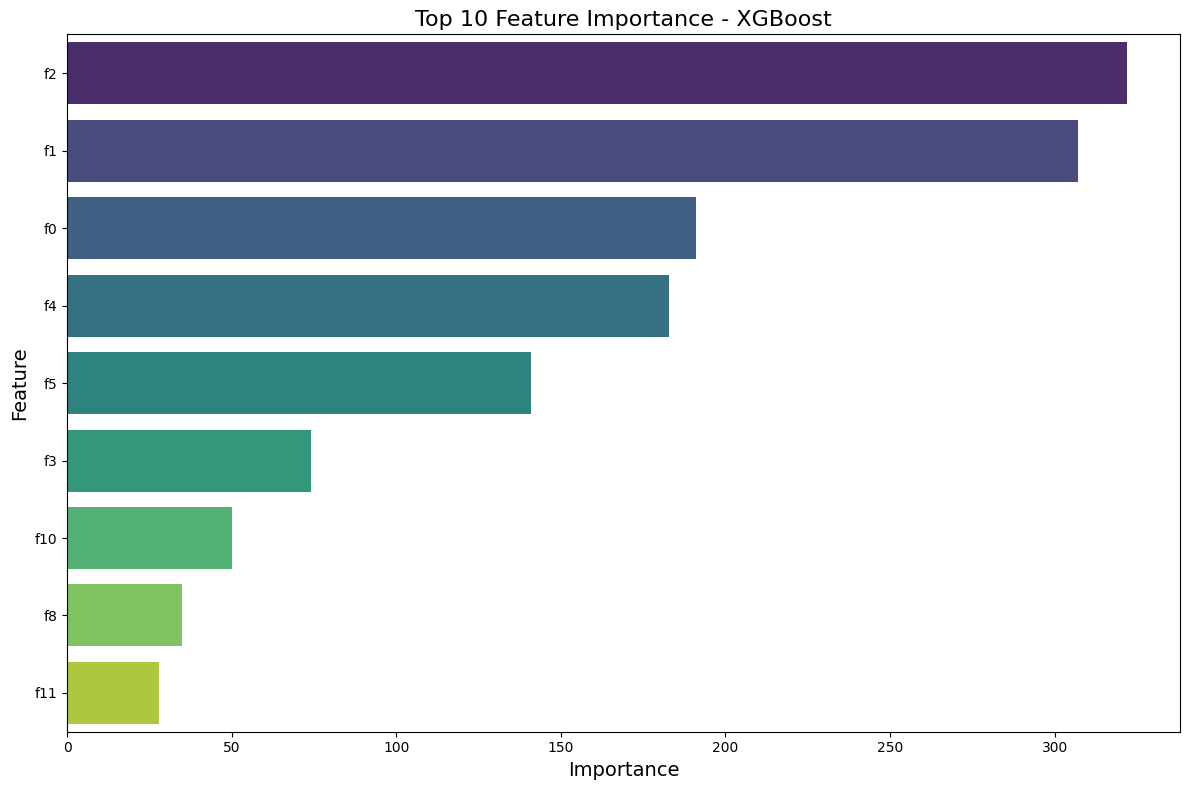

In [ ]:
# Feature importance from XGBoost
def plot_xgb_feature_importance(model):
    xgb_importance = model.get_booster().get_score(importance_type='weight')
    if not xgb_importance:
        print("No feature importance data available.")
        return

    # Convert to DataFrame and sort
    importance_df = pd.DataFrame(list(xgb_importance.items()), columns=['feature', 'importance'])
    importance_df['importance'] = importance_df['importance'].astype(float)
    importance_df = importance_df.sort_values(by='importance', ascending=False)

    # Top 10 features
    top_10_features = importance_df.head(10)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=top_10_features, palette='viridis')
    plt.title('Top 10 Feature Importance - XGBoost', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()


# Plot feature importance for XGBoost
print("Visualizing feature importance for XGBoost...")
plot_xgb_feature_importance(xgb_best)

In [ ]:
# Stacking Ensemble
print("Creating stacking ensemble...")
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_best),  # Tuned Random Forest
        ('xgb', xgb_best),  # Tuned XGBoost
        ('lr', LogisticRegression(class_weight='balanced'))  # Logistic Regression
    ],
    final_estimator=LogisticRegression(),  # Meta-learner
    cv=3  # Reduced cross-validation folds for efficiency
)

# Train the stacking model
print("Fitting stacking model...")
stacking_model.fit(X_train_processed, y_train)


Creating stacking ensemble...
Fitting stacking model...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:22:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:22:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:23:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:23:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(cv=3,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=10,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_type...
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lr',
                                LogisticRegression(class_weight='balanced'))],
                   final_estimator=LogisticRegression())


Model: Random Forest
F1 Score: 0.9227
Recall Score: 0.9290
ROC AUC Score: 0.9721

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      1029
         1.0       0.92      0.93      0.92      1028

    accuracy                           0.92      2057
   macro avg       0.92      0.92      0.92      2057
weighted avg       0.92      0.92      0.92      2057



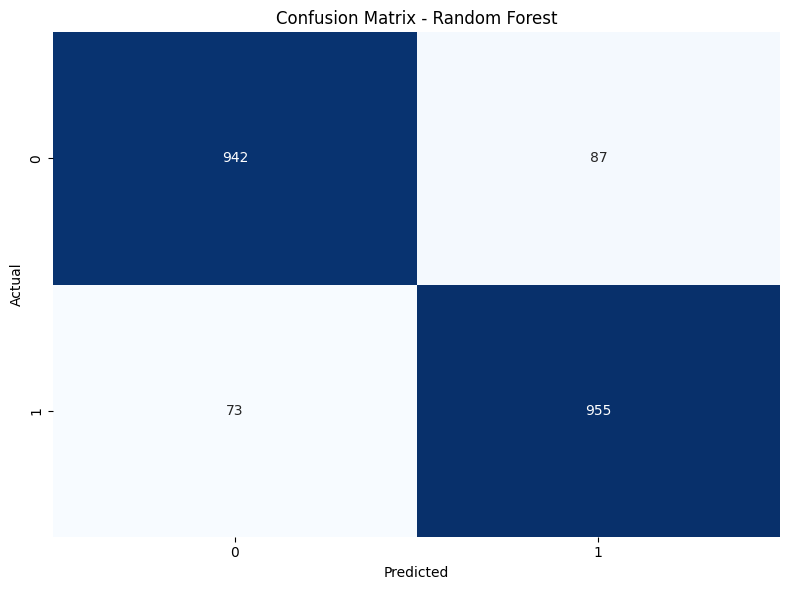


Model: XGBoost
F1 Score: 0.9841
Recall Score: 0.9922
ROC AUC Score: 0.9969

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1029
         1.0       0.98      0.99      0.98      1028

    accuracy                           0.98      2057
   macro avg       0.98      0.98      0.98      2057
weighted avg       0.98      0.98      0.98      2057



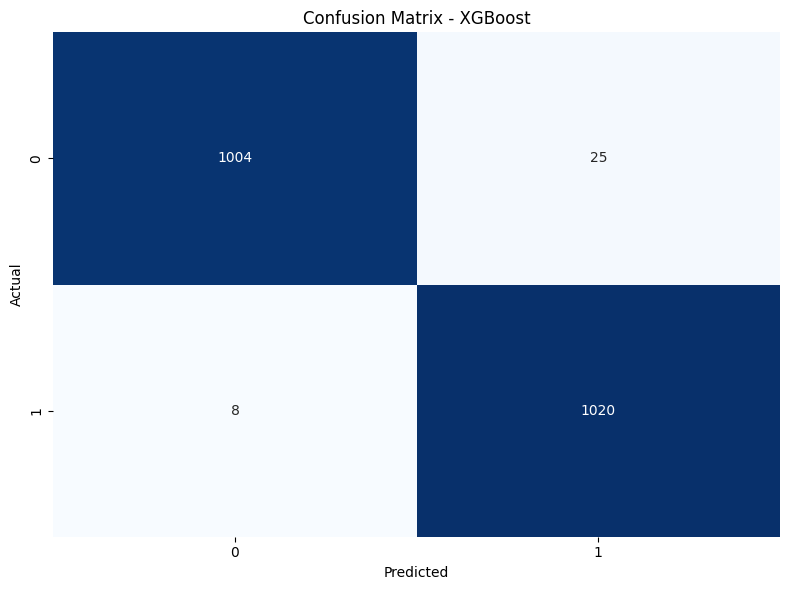


Model: Logistic Regression
F1 Score: 0.8289
Recall Score: 0.9591
ROC AUC Score: 0.9147

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.65      0.77      1029
         1.0       0.73      0.96      0.83      1028

    accuracy                           0.80      2057
   macro avg       0.84      0.80      0.80      2057
weighted avg       0.84      0.80      0.80      2057



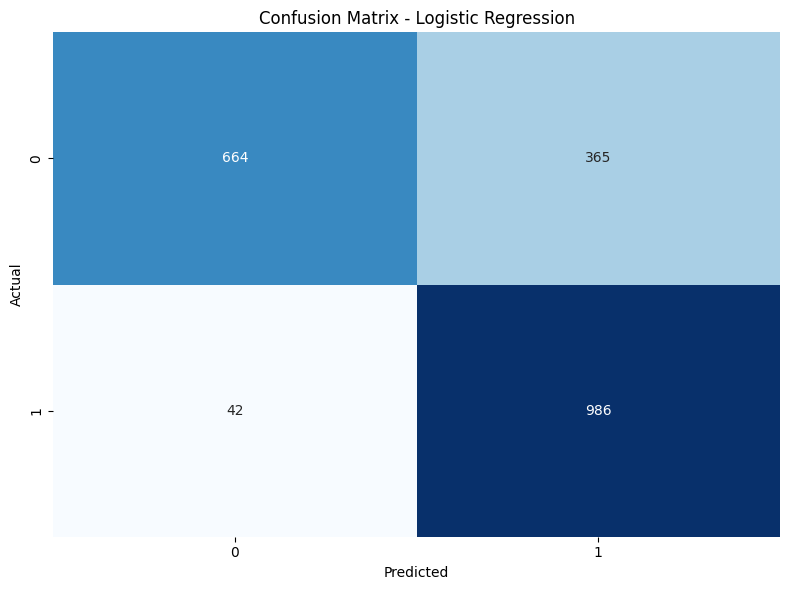


Model: Stacking Ensemble
F1 Score: 0.9855
Recall Score: 0.9922
ROC AUC Score: 0.9985

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1029
         1.0       0.98      0.99      0.99      1028

    accuracy                           0.99      2057
   macro avg       0.99      0.99      0.99      2057
weighted avg       0.99      0.99      0.99      2057



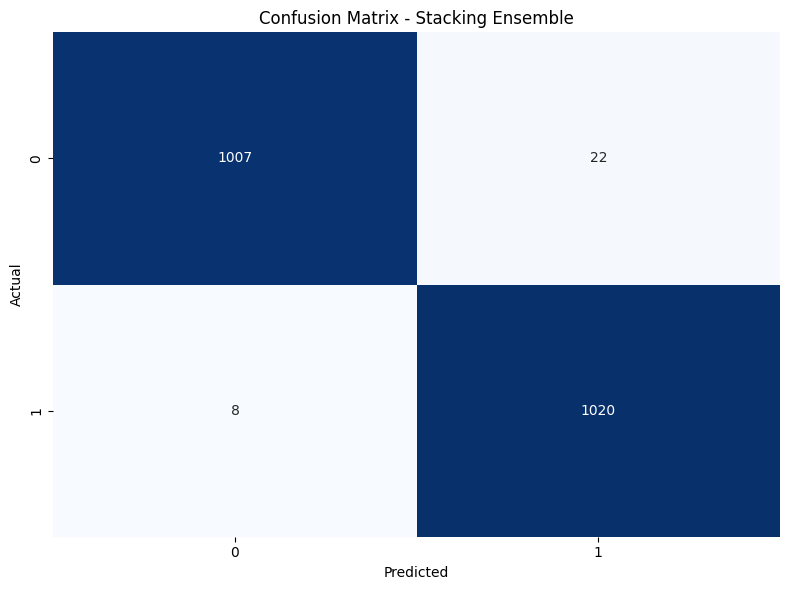

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score, recall_score

# Evaluate Model Performance
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate the model on test data using classification metrics.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\nModel: {model_name}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"Recall Score: {recall_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Evaluate Models
evaluate_model(rf_best, X_test_processed, y_test, "Random Forest")
evaluate_model(xgb_best, X_test_processed, y_test, "XGBoost")
evaluate_model(lr_model, X_test_processed, y_test, "Logistic Regression")
evaluate_model(stacking_model, X_test_processed, y_test, "Stacking Ensemble")

